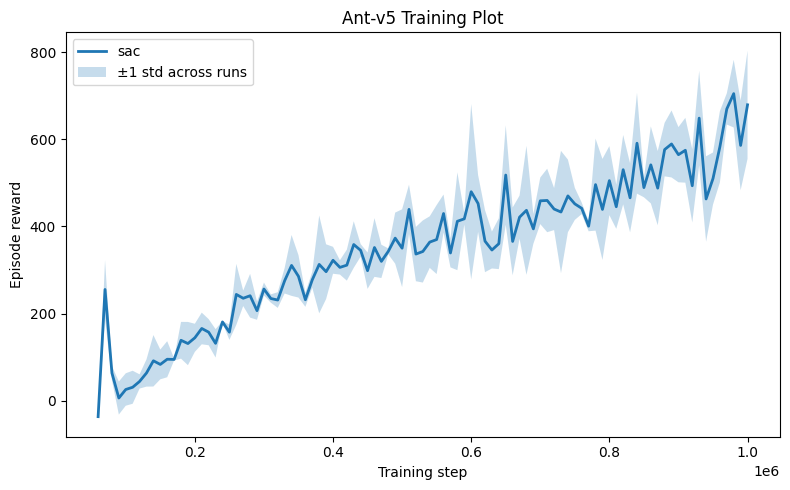

Aggregated 3 runs:
 - ./exp_sac/Ant-v5/seed127_095509/train.csv
 - ./exp_sac/Ant-v5/seed404_221645/train.csv
 - ./exp_sac/Ant-v5/seed42_221656/train.csv


In [1]:
# Jupyter-ready plotting script: mean ± std across runs
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------------------- config ---------------------
task_name = "Ant-v5"
algo = "sac"
EXP_ROOT = f"./exp_{algo}/{task_name}"          # root folder shown in your screenshot
CSV_NAME = "train.csv"    # we aggregate from this file
X_KEY = "step"
Y_KEY = "episode_reward"  # column in your CSV

PLOT_INDIVIDUAL = False   # set True to overlay faint per-run lines
# --------------------------------------------------

def find_train_csvs(exp_root: str, csv_name: str):
    # pattern matches exp/2025.11.09/*/train.csv and exp/2025.11.11/*/train.csv etc.
    # pattern = os.path.join(exp_root, "*", "*", csv_name)
    pattern = os.path.join(exp_root, "*", csv_name)
    paths = sorted(glob.glob(pattern))
    return paths

def load_one_run(path: str, x_key: str, y_key: str):
    df = pd.read_csv(path)
    # some logs use int64 for steps; ensure numeric, drop NaNs
    df = df[[x_key, y_key]].copy()
    df = df.dropna().sort_values(x_key)
    # ensure monotonically increasing steps
    df = df.groupby(x_key, as_index=False).last()
    # attach run id from folder name
    run_id = os.path.basename(os.path.dirname(path))
    df["run_id"] = run_id
    return df

paths = find_train_csvs(EXP_ROOT, CSV_NAME)
if not paths:
    raise FileNotFoundError(f"No {CSV_NAME} files found under {EXP_ROOT}/<date>/<trial>/")

runs = [load_one_run(p, X_KEY, Y_KEY) for p in paths]
df_all = pd.concat(runs, ignore_index=True)


# compute mean and std across runs per step
agg = (
    df_all
    .groupby(X_KEY)[Y_KEY]
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
agg.rename(columns={'mean': 'y_mean', 'std': 'y_std', 'count': 'n'}, inplace=True)

# plot
plt.figure(figsize=(8, 5))
if PLOT_INDIVIDUAL:
    # faint lines per run (after binning if enabled)
    for rid, sub in df_all.groupby("run_id"):
        plt.plot(sub[X_KEY], sub[Y_KEY], alpha=0.2, linewidth=1)

plt.plot(agg[X_KEY], agg["y_mean"], linewidth=2, label=f"{algo}")
plt.fill_between(
    agg[X_KEY],
    agg["y_mean"] - agg["y_std"],
    agg["y_mean"] + agg["y_std"],
    alpha=0.25,
    label="±1 std across runs"
)

plt.xlabel("Training step")
plt.ylabel("Episode reward")
plt.title(f"{task_name} Training Plot")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Aggregated {len(paths)} runs:")
for p in paths:
    print(" -", p)
